# Classification of mushroom species

The objective of this notebook is to build a model predicting the species of the given fungus picture.
In US alone there are 7500 yearly cases of fungi poisoning. Proper identification of the species could prevent deaths and hospitalization costs.

Wikipedia specifies the most toxis fungis:
https://en.wikipedia.org/wiki/List_of_poisonous_fungus_species

The analysis is done on dataset from https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images.

Taking into account the species from dataset and information from wikipedia we need to be highly alert over species like:
* Amonita
* Cortinarius
* Enteloma
* Lactarius
* some species of Boletus
* some species of Rusella

which takes 5 out of 9 species that we have in our dataset.

The aim is to build the models that would recognize those species. The metric that will be used is multiclass accuracy.

## Setup

### Installations

In [ ]:
# @title
!pip install --quiet kaggle
!pip install --quiet fastai
!pip install --quiet pytorch-lightning
!pip install --quiet torchmetrics
!pip install --quiet tensorboard
!pip install --quiet torchsummary
!pip install --quiet lime
!pip install --quiet scikit-image

### Importing libraries

In [ ]:
# @title
from google.colab import files, drive

drive.mount("/content/drive")
import os
import zipfile
import shutil
from typing import Tuple, List
import random
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import LambdaLR

torch.manual_seed(42)

from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms.functional as f
from torchvision.transforms import AutoAugmentPolicy, AutoAugment

from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping, ModelCheckpoint

from torchmetrics.classification import Accuracy

from torchsummary import summary

import warnings

warnings.filterwarnings("ignore")

Mounted at /content/drive


### Helper functions

In [ ]:
# @title
def list_directory_tree_with_os_walk(starting_directory: str) -> Tuple[List]:
    """Creates list of species of mushrooms and calculates the number
    of files in each of directory.
    Args:
        starting directory(str)
    Returns:
        list of directories with mushroom species
        list of number of files in each directory"""

    roots = []
    file_nr = []
    for root, directories, files in os.walk(starting_directory):
        root = root.split("/")[-1]
        roots.append(root)
        file_nr.append(len(files))
    return roots[1:], file_nr[1:]


def dimension(path: str) -> Tuple:
    """Gets the dimensions of the picture
    from the picture path.
    Args:
        path (str): the path
    Returns:
        width, height (Tuple)"""

    image = Image.open(path)
    width, height = image.size
    return width, height


def assign_data_split(x: str) -> str:
    """Mapping function that assigns split to the file path.
    Args:
        x (str): image path
    Returns:
        (str): assigned split word"""

    if x in X_train.tolist():
        return "train"
    elif x in X_val.tolist():
        return "valid"
    elif x in X_test.tolist():
        return "test"


def copy_paths(folder: str, path: str) -> None:
    """Copies file to a destination folder based on columns from df_files.
    Args:
        folder (str): folder
        path (str): file path"""

    destination = f"/content/data/{folder}/{path}"
    paths = df_files.loc[(df_files["split"] == folder) & (df_files["species"] == path)][
        "path"
    ].tolist()
    for path in paths:
        shutil.copy(path, destination)


def display_image_grid(
    images: List, labels: List, rows: int = 2, cols: int = 5
) -> None:
    """
    Display a grid of images with labels.
    Args:
        images (list of numpy arrays): list of images to display.
        labels (list of str): list of labels for each image.
        rows (int): number of rows in the grid (default is 2).
        cols (int): number of columns in the grid (default is 5).
    """

    if len(images) != rows * cols:
        raise ValueError("Number of images should match rows * cols.")

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))
        ax.set_title(labels[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def augment_images(source_dir: str, num_augmentations: int = 5) -> None:
    """
    Augment images in a source directory and save them to a destination directory.

    Args:
        source_dir (str): path to the source directory containing input images.
        num_augmentations (int): number of augmentations to generate per
        input image (default is 5).
    """

    augmentation = transforms.Compose(
        [
            AutoAugment(policy=AutoAugmentPolicy.IMAGENET),
        ]
    )
    file_list = os.listdir(source_dir)

    for i in range(num_augmentations):
        random_file = random.choice(file_list)
        random_path = os.path.join(source_dir, random_file)
        input_image = Image.open(random_path)
        augmented_image = augmentation(input_image)
        new = f"{os.path.splitext(random_file)[0]}_aug_{i+1}{os.path.splitext(random_file)[1]}"
        augmented_image.save(os.path.join(source_dir, new))


def get_channel_mean(path: str, axis: int) -> float:
    """Calculates mean value of chosen channel
    in the image.
    Args:
        path (str): a path to the image
        axis (int): the axis of the channel
    Returns:
        mean (float): mean value of channel"""

    numpy_image = Image.open(path).split()[axis]
    return np.mean(numpy_image)


def get_channel_std(path: str, axis: int) -> float:
    """Calculates standard deviation value of chosen channel
    in the image.
    Args:
        path (str): a path to the image
        axis (int): the axis of the channel
    Returns:
        mean (float): mean value of channel"""

    numpy_image = Image.open(path).split()[axis]
    return np.std(numpy_image)


def plot_training(
    epochs: List[int],
    train_losses: List,
    valid_losses: List,
    train_acces: List,
    valid_acces: List,
) -> None:
    """Plots two graphs of losses and accuracies for training and validation
    on each epoch.
    Args:
        epochs (list): range of epochs
        train_losses (list): losses on all epochs for train data
        valid_losses (list): losses on all epochs for validation data
        train_acces (list): accuracies on all epochs for train data
        valid_acces (list): accuracies on all epochs for validation data"""

    if len(valid_losses) != len(train_losses):
        valid_losses = valid_losses[1:]
    if len(valid_acces) != len(train_acces):
        valid_acces = valid_acces[1:]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(epochs, valid_losses, label="Validation Loss")
    ax1.plot(epochs, train_losses, label="Training Loss")
    ax1.legend()
    ax1.set_title("Losses on epochs")
    ax2.plot(epochs, valid_acces, label="Validation accuracy")
    ax2.plot(epochs, train_acces, label="Trining accuracy")
    ax2.legend()
    ax2.set_title("Accuracies on epochs")
    plt.show()


def get_image(path: str) -> Image.Image:
    """Convertes an image stored in a path to RGB PIL image.
    Args:
        path (str): path to the file
    Returns:
        PIL Image"""
    with open(os.path.abspath(path), "rb") as file:
        with Image.open(file) as img:
            return img.convert("RGB")


def get_pil_transform() -> transforms.Compose:
    """Returns an object for transforming PIL images."""
    transf = transforms.Compose(
        [
            ResizeWithPad(300, 300),
            transforms.CenterCrop((224, 224)),
        ]
    )
    return transf


def get_preprocess_transform() -> transforms.Compose:
    """Returns an object for transforming and normalizing PIL image
    to tensor."""
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    transf = transforms.Compose([transforms.ToTensor(), normalize])
    return transf


def batch_predict(images: List[Image.Image]) -> List[float]:
    """Performs predictions with padded_model on list of PIL images and
    returns ptobabilities for all classes.
    Args:
        images (List[Image.Image]): list of pil images
    Returns:
        probabilities for all classes (List[float])"""
    padded_model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    padded_model.to(device)
    batch = batch.to(device)

    logits = padded_model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


def plot_explanations(path_list: List[str], title: str) -> None:
    """Plots 5 images with mask to see which arease contribute to top
    predictions.
    Args:
        path_list (List): list with paths
        title (str): title od subplots
    """
    fig, ax = plt.subplots(2, 5, figsize=(18, 6))
    fig.suptitle(title)
    for i, path in zip(range(5), path_list[:5]):
        img = get_image(path)
        explainer = lime_image.LimeImageExplainer(verbose=False)
        explanation = explainer.explain_instance(
            np.array(pill_transf(img)),
            batch_predict,
            top_labels=5,
            hide_color=0,
            num_samples=1000,
        )

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False,
        )
        img_boundry1 = mark_boundaries(temp / 255.0, mask)
        ax[0, i].imshow(img_boundry1)
        ax[0, i].set_title(
            f"{label_mapper[np.argmax(batch_predict([img]))]} {np.max(batch_predict([img])):.2f}"
        )
        ax[0, i].axis("off")

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=10,
            hide_rest=False,
        )
        img_boundry2 = mark_boundaries(temp / 255.0, mask)
        ax[1, i].imshow(img_boundry2)
        ax[1, i].axis("off")


class ResizeWithPad:
    """Resize an input image to a target width and height while
    maintaining the original aspect ratio. If the aspect ratio of input image
    is different from the target aspect ratio, the input image is padded."""

    def __init__(self, width: int = 224, height: int = 224):
        self.w = width
        self.h = height

    def __call__(self, image: Image.Image) -> Image.Image:
        input_width, input_height = image.size
        ratio_target = self.w / self.h
        ratio_input = input_width / input_height

        # Calculate the required padding on all sides
        if round(ratio_input, 2) != round(ratio_target, 2):
            if ratio_input < ratio_target:
                # Image is taller than the target aspect ratio
                wp = int((input_height * ratio_target - input_width) / 2)
                image = transforms.functional.pad(image, (wp, 0, wp, 0), 0, "constant")
            else:
                # Image is wider than the target aspect ratio
                hp = int((input_width / ratio_target - input_height) / 2)
                image = transforms.functional.pad(image, (0, hp, 0, hp), 0, "constant")

        # Resize the padded image to the target size
        return transforms.functional.resize(image, [self.h, self.w])

## Downloading data

To download the data:
* download kaggle API token in .json format from kaggle
* when promped download the file with kaggle credentials

In [ ]:
# Downlading file with kaggle API token
files.upload()
# Seetting kaggle
!pip show kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config view
# Downlading dataset
!kaggle datasets download -d maysee/mushrooms-classification-common-genuss-images
# Extracting download to data file
zip_file_path = "/content/mushrooms-classification-common-genuss-images.zip"
with zipfile.ZipFile(zip_file_path, "r") as d:
    d.extractall("/content/data")

Saving kaggle.json to kaggle.json
Name: kaggle
Version: 1.5.16
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: bleach, certifi, python-dateutil, python-slugify, requests, six, tqdm, urllib3
Required-by: 
Configuration values from /root/.kaggle
- username: malgorzatakolka
- path: None
- proxy: None
- competition: None
 99% 1.84G/1.85G [00:25<00:00, 127MB/s]
100% 1.85G/1.85G [00:25<00:00, 77.1MB/s]


## Inspecting the structure of the dataset

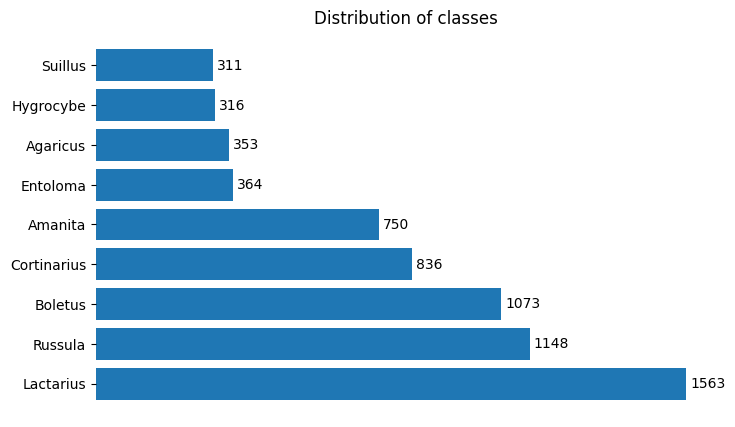

In [ ]:
# Getting names of species and count of pictures for each species
species, count = list_directory_tree_with_os_walk("/content/data/Mushrooms")

df = pd.DataFrame()
df["Species"] = species
df["Count"] = count
df.sort_values(by=["Count"], ascending=False, inplace=True)
plt.figure(figsize=(8, 5))
plt.barh(df["Species"], df["Count"])
for i, v in enumerate(df["Count"]):
    plt.text(v + 10, i, str(v), va="center", fontsize=10)
sns.despine(bottom=True, left=True)
plt.xticks([])
plt.title("Distribution of classes")
plt.show()

The data is imbalanced with some of the species having 5 times more samples. Later in the modeling stage the data will be balanced by augmentation.

## Visual analysis

In the dataset there are some pictures which represent:
* a mushrom in the picture corner - big chance of ceentral cropping outputing not a representative of a mushroom
* a microscopic representation of spores,
* 2 pictures of fluorescent representation of a mushroom,
* random pictures which don't represent a mushroom.

In [ ]:
visual_check = [
    "Entoloma/262_6HfhcF6lKRQ.jpg",
    "Lactarius/0127_1R8TZJseXgY.jpg",
    "Lactarius/0489_6GuHfi0wmko.jpg",
    "Cortinarius/920_wzMtMlkv4bE.jpg",
    "Cortinarius/919_KmB7cv33TjM.jpg",
    "Boletus/0775_vEDC-0BKXgU.jpg",
    "Boletus/0726_wNJGG_syL80.jpg",
    "Boletus/0419_Cl4EMlssBM4.jpg",
    "Rusulla/456_WQ6cMYYeSN0.jpg",
    "Rusulla/341_Pd04s_MBa4g.jpg",
    "Rusulla/151_yX7oI-mM9hk.jpg",
    "Rusulla/043_a_5lm55zCVc.jpg",
    "Lactarius/27_A77QQ1QPZ1E.jpg" "Boletus/0572_zdESww0j-to.jpg",
    "Amanita/046_55Y02Q5s8MQ.jpg",
    "Lactarius/0375_E_5sHNAa0DU.jpg",
    "Boletus/0751_4vQkdVoCs54.jpg",
    "Amanita/594_XXHPZeq_x3Q.jpg",
    "Amanita/557_1yRw0j3Wjow.jpg",
    "Rusulla/419_KOrBTHYCStg.jpg",
    "Agaricus/273_ZwxysL6gjVQ.jpg",
    "Cortinarius/921_InRVQADtZNo.jpg",
    "Agaricus/249_moW6X1JYYoE.jpg",
    "Rusulla/582_DHWXSG9TSHQ.jpg",
]

# Get all paths of images
filenames = []
for root, directories, files in os.walk("/content/data/Mushrooms"):
    for f in files:
        filename = os.path.join(root, f)
        filenames.append(filename)

# Crating dataframe which will hold the path and species
df_files = pd.DataFrame()
df_files["path"] = filenames
df_files["species"] = df_files["path"].apply(lambda x: x.split("/")[4])
df_files.head()

path   species
0  /content/data/Mushrooms/Agaricus/029_ZksYQQBGVIg.jpg  Agaricus
1  /content/data/Mushrooms/Agaricus/194_T28G7rXl90k.jpg  Agaricus
2  /content/data/Mushrooms/Agaricus/047__bHHefe5kng.jpg  Agaricus
3  /content/data/Mushrooms/Agaricus/016_qNYODERZEms.jpg  Agaricus
4  /content/data/Mushrooms/Agaricus/070_bQ4dCaNd0yc.jpg  Agaricus

In [ ]:
# Dropping images from visual check
paths_to_drop = [os.path.join("/content/data/Mushrooms", path) for path in visual_check]
indicis_to_drop = df_files.loc[df_files["path"].isin(paths_to_drop)].index.tolist()
df_files.drop(indicis_to_drop, inplace=True)

In [ ]:
# Adding extension
df_files["extension"] = df_files["path"].apply(lambda x: x[-4:])

# Adding dimensions
df_files["width_height"] = df_files["path"].map(dimension)

# Adding number of channels
df_files["channels"] = df_files["path"].apply(lambda x: len(Image.open(x).getbands()))

# Adding columns with sizes
df_files["width"] = df_files["width_height"].apply(lambda x: x[0])
df_files["height"] = df_files["width_height"].apply(lambda x: x[1])
df_files["dimension_ratio"] = df_files["width"] / df_files["height"]

In [ ]:
print("Unique extensions: ", df_files["extension"].unique().tolist())
print("Unique number of channels: ", df_files["channels"].unique().tolist())

Unique extensions:  ['.jpg']
Unique number of channels:  [3, 1]


In [ ]:
# Dropping files with 1 channel
df_files.drop(df_files.loc[df_files["channels"] == 1].index.tolist(), inplace=True)

In [ ]:
# Columns for channels statistics
df_files["R_mean"] = df_files["path"].apply(lambda x: get_channel_mean(x, 0))
df_files["G_mean"] = df_files["path"].apply(lambda x: get_channel_mean(x, 1))
df_files["B_mean"] = df_files["path"].apply(lambda x: get_channel_mean(x, 2))
df_files["R_std"] = df_files["path"].apply(lambda x: get_channel_std(x, 0))
df_files["G_std"] = df_files["path"].apply(lambda x: get_channel_std(x, 1))
df_files["B_std"] = df_files["path"].apply(lambda x: get_channel_std(x, 2))
df_files.head()

path   species extension  \
0  /content/data/Mushrooms/Entoloma/067_rS4ywAs7pBY.jpg  Entoloma      .jpg   
1  /content/data/Mushrooms/Entoloma/232_dtwaIYms3B0.jpg  Entoloma      .jpg   
2  /content/data/Mushrooms/Entoloma/356_eaWgY_PpkQ4.jpg  Entoloma      .jpg   
3  /content/data/Mushrooms/Entoloma/117_m3SB1IX3jU0.jpg  Entoloma      .jpg   
4  /content/data/Mushrooms/Entoloma/198_fmlPWLGNaaw.jpg  Entoloma      .jpg   

  width_height  channels  width  height  dimension_ratio      R_mean  \
0   (800, 547)         3    800     547         1.462523   74.268857   
1   (798, 599)         3    798     599         1.332220   97.954795   
2   (800, 543)         3    800     543         1.473297   98.632608   
3   (800, 533)         3    800     533         1.500938   92.319508   
4   (880, 660)         3    880     660         1.333333  106.469609   

       G_mean     B_mean      R_std      G_std      B_std  
0   65.852925  50.606940  53.791034  51.800223  49.104959  
1   91.085826  83.472810  52.204548  52.518882  49.828745  
2   98.995642  72.685654  70.389393  64.428199  62.647354  
3  117.553917  76.596168  71.537221  58.448156  75.821744  
4  111.961515  68.828979  54.701524  50.836024  63.833195

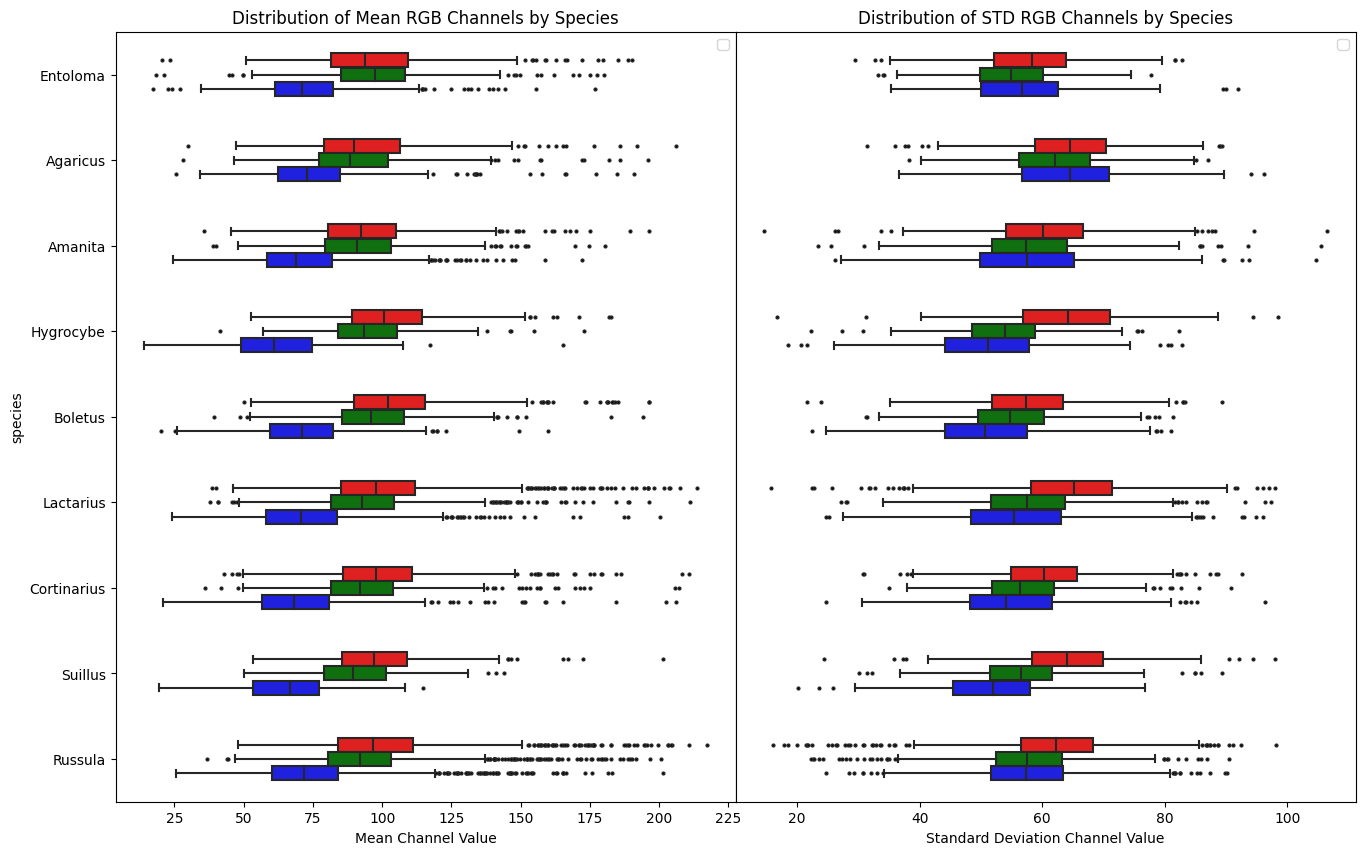

In [ ]:
# Melt the DataFrame to create a 'channel' column for std and mean
df_mean = pd.melt(
    df_files,
    id_vars=["species"],
    value_vars=["R_mean", "G_mean", "B_mean"],
    var_name="channel",
)
df_std = pd.melt(
    df_files,
    id_vars=["species"],
    value_vars=["R_std", "G_std", "B_std"],
    var_name="channel",
)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
plt.subplots_adjust(wspace=0)
outlier_props = dict(
    marker="o", markerfacecolor="black", markersize=2, linestyle="none"
)
sns.boxplot(
    data=df_mean,
    x="value",
    y="species",
    hue="channel",
    palette={"R_mean": "r", "G_mean": "g", "B_mean": "b"},
    width=0.5,
    ax=ax1,
    flierprops=outlier_props,
)
ax1.set(
    xlabel="Mean Channel Value", title="Distribution of Mean RGB Channels by Species"
)
ax1.legend([])
sns.boxplot(
    data=df_std,
    x="value",
    y="species",
    hue="channel",
    palette={"R_std": "r", "G_std": "g", "B_std": "b"},
    width=0.5,
    ax=ax2,
    flierprops=outlier_props,
)
ax2.set(
    xlabel="Standard Deviation Channel Value",
    title="Distribution of STD RGB Channels by Species",
    ylabel="",
    yticks=[],
)
ax2.legend([])
plt.show()

* In all images the least dominant hue is given by the blue channel.
* Some images with high mean vlaues for a channel are overexposing the picture with that colour channel.  
* Hygrocybe specied has highier std for red channel which would suggest the differences in saturation with red colour.

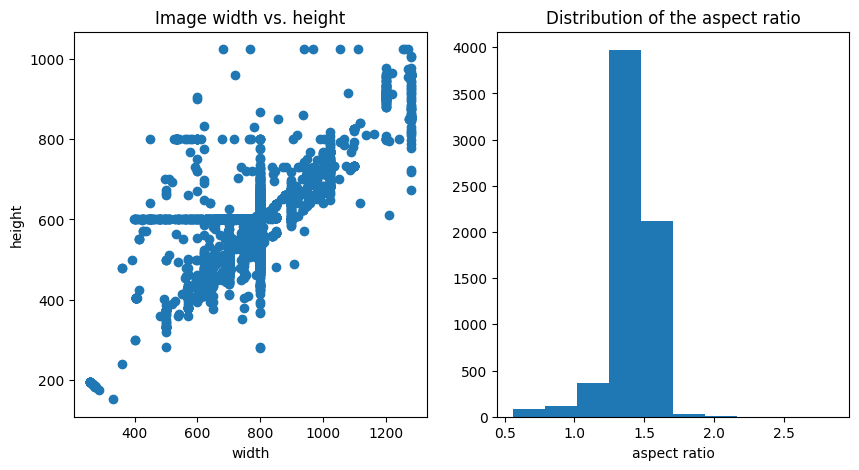

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(x=df_files["width"], y=df_files["height"])
ax1.set(title="Image width vs. height", xlabel="width", ylabel="height")
ax2.hist(df_files["dimension_ratio"])
ax2.set(title="Distribution of the aspect ratio", xlabel="aspect ratio");

The dataset has aspect ratio for most of the images within 0.7 and 2.0 we will check if the use of non destructive resizing -> pad approach will improve the performance of the model.

## Stratified data split and folder creation for train, validation and testing

In [ ]:
# Splitting data
X = df_files["path"]
y = df_files["species"]

X_train, X_t, y_train, y_t = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_t, y_t, test_size=0.5, stratify=y_t, random_state=42
)

# Mapping splits with split column
df_files["split"] = df_files["path"].map(assign_data_split)

# Preparation of directories
directory_list = [
    f"/content/data/{z}/{s}"
    for z in ["train", "valid", "test"]
    for s in df_files["species"].unique().tolist()
]
for directory in directory_list:
    os.makedirs(directory, exist_ok=True)

# Coping files
for z in ["train", "valid", "test"]:
    for s in df_files["species"].unique().tolist():
        copy_paths(z, s)

In [ ]:
drive_path = "/content/data"
train_roots, train_files = list_directory_tree_with_os_walk(f"{drive_path}/train")
valid_roots, valid_files = list_directory_tree_with_os_walk(f"{drive_path}/valid")
test_roots, test_files = list_directory_tree_with_os_walk(f"{drive_path}/test")
print("Species: ", train_roots)
print("Train: ", train_files)
print("Valid: ", valid_files)
print("Test: ", test_files)

Species:  ['Agaricus', 'Amanita', 'Russula', 'Boletus', 'Entoloma', 'Hygrocybe', 'Cortinarius', 'Lactarius', 'Suillus']
Train:  [246, 523, 803, 747, 254, 221, 583, 1092, 218]
Valid:  [52, 112, 172, 160, 54, 48, 125, 234, 47]
Test:  [53, 112, 173, 160, 55, 47, 125, 234, 46]


## Displaying random samples of pictures from training set

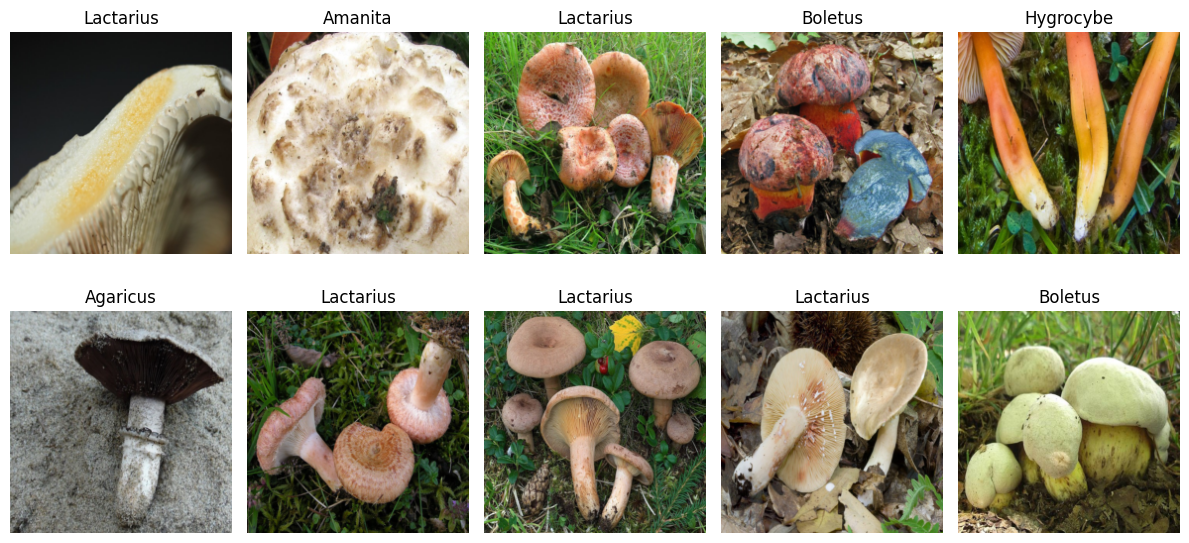

In [ ]:
# Creating transformer
tfms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Creating data loader
train_data = datasets.ImageFolder(f"/content/data/train", transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

# Displaying pictures for first batch of 10 mushrooms
label_mapper = {i: c for i, c in enumerate(train_data.classes)}
images, labels = next(iter(train_loader))
labels = [label_mapper[label.item()] for label in labels]
display_image_grid(images, labels)

In [ ]:
label_mapper

{0: 'Agaricus',
 1: 'Amanita',
 2: 'Boletus',
 3: 'Cortinarius',
 4: 'Entoloma',
 5: 'Hygrocybe',
 6: 'Lactarius',
 7: 'Russula',
 8: 'Suillus'}

## Model Building using FastAI and ResNet18

First experiment will be focused on creating model using FastAI library.
The data won't be augmented so the training will take less time.

TODO:
* create dataloader and display batch
* create learner
* find the best learning rate
* finetune the model with heavy penalization
* analyze model performance


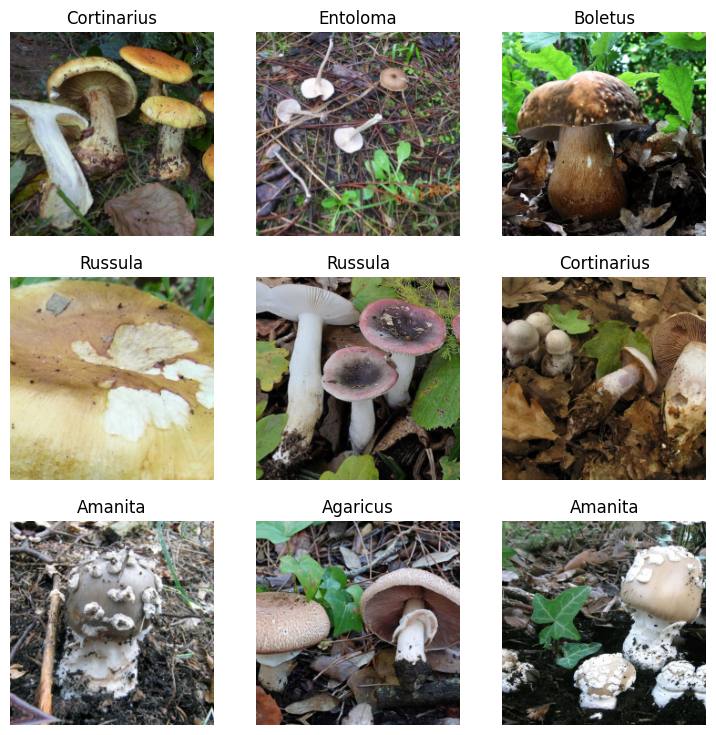

In [ ]:
dls = ImageDataLoaders.from_folder(
    path="/content/data",
    train="train",
    valid="valid",
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)],
)

dls.show_batch()

In [ ]:
# Instantiating learner
learn = cnn_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


SuggestedLRs(valley=0.0014454397605732083)

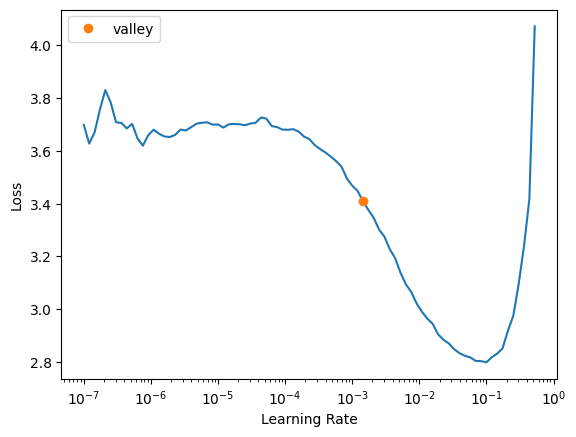

In [ ]:
# Finding learning rate
learn.lr_find()

In [ ]:
# Fine tuning the model
learn.fine_tune(epochs=10, base_lr=0.0014, wd=0.8)

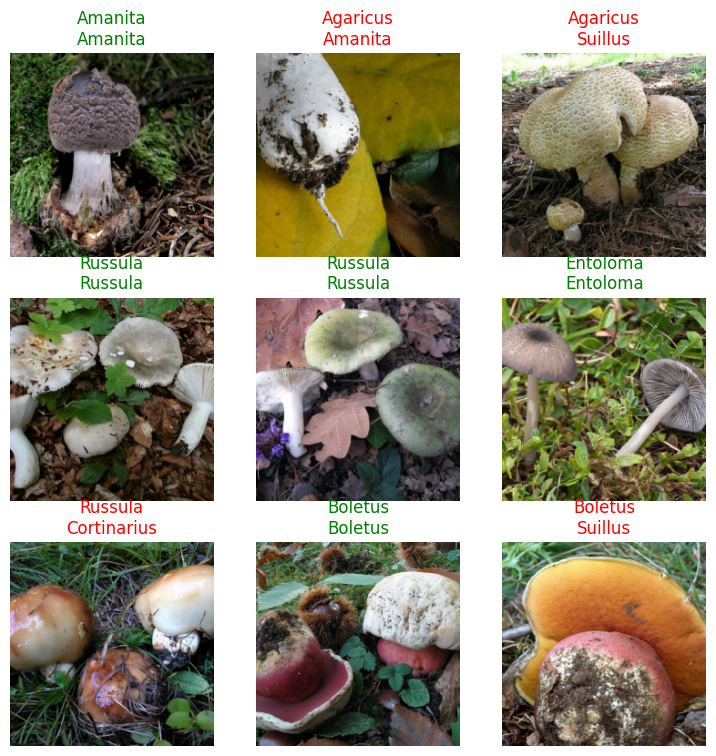

In [ ]:
# Results for first 9 mushrooms
learn.show_results()

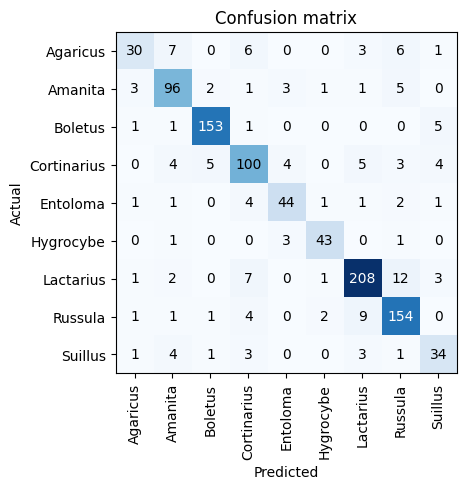

In [ ]:
# Creating confusion matrix
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

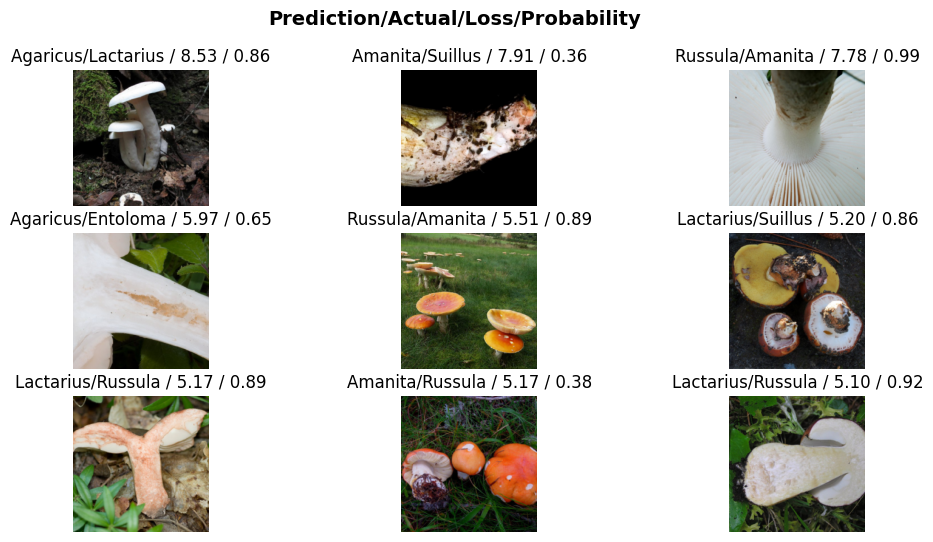

In [ ]:
interpretation.plot_top_losses(9, figsize=(12, 6))

The classes that have similar shape or mashrooms were misclassified although they had the highiest number of representatives.

The most worring cases are the species which are toxic but are classified as eadible. In the graph displayed above non of those may actually cause harm to the mushroom picker.

## Model building with Pytorch-lightning and ResNet18

1. Experiment without data augmentation
2. Experiment with data augmentation

### Defining the model

In [ ]:
class MushroomResNet(pl.LightningModule):
    """MushroomResNet: A PyTorch Lightning Module for Mushroom Classification using ResNet18
    and dropout and linear layer.

    Args:
        nr_classes (int, optional): Number of classes for classification. Defaults to 9.
        max_lr (float, optional): Maximum learning rate for the optimizer. Defaults to 0.03.
        min_lr (float, optional): Minimum learning rate for the optimizer. Defaults to 0.0005.
    """

    def __init__(
        self, nr_classes: int = 9, max_lr: float = 0.03, min_lr: float = 0.0005
    ):
        super().__init__()
        self.nr_classes = nr_classes
        self.max_lr = max_lr
        self.min_lr = min_lr
        weights = ResNet18_Weights.DEFAULT
        backbone = resnet18(weights=weights)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.6), nn.Linear(num_filters, self.nr_classes)
        )
        self.accuracy = Accuracy(task="multiclass", num_classes=self.nr_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.feature_extractor(x).flatten(1)
        out = self.classifier(out)
        return out

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        loss, acc, outputs, y = self._common_step(batch, batch_idx)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, on_step=False, prog_bar=True)
        return {"loss": loss, "acc": acc}

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        loss, acc, outputs, y = self._common_step(batch, batch_idx)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, on_step=False, prog_bar=True)
        return {"loss": loss, "acc": acc}

    def test_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        loss, acc, outputs, y = self._common_step(batch, batch_idx)
        self.log("test_loss", loss)
        self.log("test_acc", acc, on_epoch=True)
        return {"loss": loss, "acc": acc}

    def _common_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        images, labels = batch
        outputs = self.forward(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(torch.argmax(outputs, dim=1), labels)
        return loss, acc, outputs, labels

    def predict_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int
    ) -> dict:
        images, labels = batch
        outputs = self.forward(images)
        pred = torch.argmax(outputs, dim=1)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.max_lr, weight_decay=0.6
        )
        scheduler = {
            "scheduler": LambdaLR(
                optimizer, lr_lambda=lambda epoch: self.adjust_lr(epoch)
            ),
            "interval": "epoch",
            "frequency": 1,
        }
        return [optimizer], [scheduler]

    def adjust_lr(self, epoch: int) -> float:
        return self.min_lr + (self.max_lr - self.min_lr) * (
            1 - epoch / self.trainer.max_epochs
        )


class MyPrintingCallback(Callback):
    """MyPrintingCallback inherits from pytorch_lightening callback class.
    It prints:
        start of training,
        metrics after each epoch for train and validation
        plots graphs at the end of each training with results."""

    def __init__(self):
        self.train_losses = []
        self.valid_losses = []
        self.train_acces = []
        self.valid_acces = []

    def on_train_start(self, trainer, pl_module):
        print("Training is starting")

    def on_train_epoch_end(self, trainer, pl_module):
        train_acc = trainer.callback_metrics["train_acc"]
        self.train_acces.append(train_acc.item())
        train_loss = trainer.callback_metrics["train_loss"]
        self.train_losses.append(train_loss.item())
        print(
            f"Epoch {trainer.current_epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}"
        )

    def on_validation_epoch_end(self, trainer, pl_module):
        valid_acc = trainer.callback_metrics["val_acc"]
        self.valid_acces.append(valid_acc.item())
        valid_loss = trainer.callback_metrics["val_loss"]
        self.valid_losses.append(valid_loss.item())
        print(
            f"Epoch {trainer.current_epoch}: valid_loss={valid_loss:.4f}, valid_acc={valid_acc:.4f}"
        )

    def on_fit_end(self, trainer, pl_module):
        epochs = range(trainer.current_epoch)
        plot_training(
            epochs,
            self.train_losses,
            self.valid_losses,
            self.train_acces,
            self.valid_acces,
        )


early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")
model_checkpoint = ModelCheckpoint(
    monitor="val_loss",
    filename="model-{epoch:02d}-{val_loss:.4f}",
    save_top_k=2,
    mode="min",
)
logger = TensorBoardLogger(
    "/content/drive/MyDrive/Colab/know_your_mashroom", name="mushroom_exp"
)

In [ ]:
# Defining transformations
tfms = transforms.Compose(
    [
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Defining dataloaders
train_data = datasets.ImageFolder("/content/data/train", transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

valid_data = datasets.ImageFolder("/content/data/valid", transform=tfms)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=False)

test_data = datasets.ImageFolder("/content/data/test", transform=tfms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

### Model without data augmentation

In [ ]:
model = MushroomResNet()
for param in model.parameters():
    param.requires_grad = True
trainer = pl.Trainer(
    max_epochs=30,
    logger=logger,
    callbacks=[early_stopping, MyPrintingCallback(), model_checkpoint],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 11.2 M
1 | classifier        | Sequential         | 4.6 K 
2 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: valid_loss=2.0161, valid_acc=0.0625
Training is starting


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: valid_loss=1.6796, valid_acc=0.4811
Epoch 0: train_loss=1.2643, train_acc=0.5731


Validation: 0it [00:00, ?it/s]

Epoch 1: valid_loss=1.1186, valid_acc=0.6285
Epoch 1: train_loss=0.8519, train_acc=0.7120


Validation: 0it [00:00, ?it/s]

Epoch 2: valid_loss=0.9008, valid_acc=0.7042
Epoch 2: train_loss=0.6521, train_acc=0.7834


Validation: 0it [00:00, ?it/s]

Epoch 3: valid_loss=1.0555, valid_acc=0.6554
Epoch 3: train_loss=0.5200, train_acc=0.8297


Validation: 0it [00:00, ?it/s]

Epoch 4: valid_loss=1.1737, valid_acc=0.6484
Epoch 4: train_loss=0.4085, train_acc=0.8728


Validation: 0it [00:00, ?it/s]

Epoch 5: valid_loss=1.3830, valid_acc=0.5857
Epoch 5: train_loss=0.3228, train_acc=0.8967


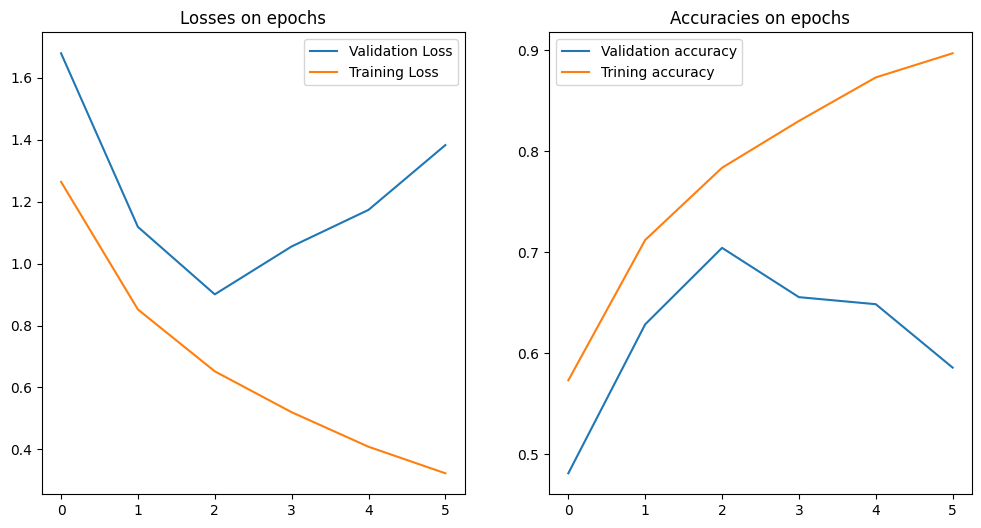

CPU times: user 5min 51s, sys: 4.89 s, total: 5min 56s
Wall time: 6min 38s


In [ ]:
%%time
trainer.fit(model, train_loader, valid_loader)

The model started overfitting after 2 epoch.

### Model with augmented and balanced dataset

In this experiment the data will be augmented so each specie has 2500 sample images.

In [ ]:
# Augmenting data to get 2500 images from each class in the training set
nr_samples = 2500
for root in train_roots:
    source_dir = f"/content/data/train/{root}"
    nr_files = len(os.listdir(source_dir))
    num_augmentations = nr_samples - nr_files
    augment_images(source_dir, num_augmentations)

In [ ]:
# Inspecting distribution of samples
drive_path = "/content/data"
train_roots, train_files = list_directory_tree_with_os_walk(f"{drive_path}/train")
valid_roots, valid_files = list_directory_tree_with_os_walk(f"{drive_path}/valid")
test_roots, test_files = list_directory_tree_with_os_walk(f"{drive_path}/test")
print("Species: ", train_roots)
print("Train: ", train_files)
print("Valid: ", valid_files)
print("Test: ", test_files)

Species:  ['Agaricus', 'Amanita', 'Russula', 'Boletus', 'Entoloma', 'Hygrocybe', 'Cortinarius', 'Lactarius', 'Suillus']
Train:  [2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500]
Valid:  [52, 112, 172, 160, 54, 48, 125, 234, 47]
Test:  [53, 112, 173, 160, 55, 47, 125, 234, 46]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 11.2 M
1 | classifier        | Sequential         | 4.6 K 
2 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: valid_loss=2.6015, valid_acc=0.0156
Training is starting


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: valid_loss=1.3707, valid_acc=0.5876
Epoch 0: train_loss=2.0050, train_acc=0.2885


Validation: 0it [00:00, ?it/s]

Epoch 1: valid_loss=1.0593, valid_acc=0.6624
Epoch 1: train_loss=1.3372, train_acc=0.5434


Validation: 0it [00:00, ?it/s]

Epoch 2: valid_loss=0.8794, valid_acc=0.7141
Epoch 2: train_loss=1.0197, train_acc=0.6599


Validation: 0it [00:00, ?it/s]

Epoch 3: valid_loss=0.7693, valid_acc=0.7570
Epoch 3: train_loss=0.8196, train_acc=0.7327


Validation: 0it [00:00, ?it/s]

Epoch 4: valid_loss=0.6980, valid_acc=0.7769
Epoch 4: train_loss=0.6712, train_acc=0.7924


Validation: 0it [00:00, ?it/s]

Epoch 5: valid_loss=0.6522, valid_acc=0.7769
Epoch 5: train_loss=0.5561, train_acc=0.8291


Validation: 0it [00:00, ?it/s]

Epoch 6: valid_loss=0.6093, valid_acc=0.7998
Epoch 6: train_loss=0.4647, train_acc=0.8654


Validation: 0it [00:00, ?it/s]

Epoch 7: valid_loss=0.5913, valid_acc=0.8088
Epoch 7: train_loss=0.3757, train_acc=0.9016


Validation: 0it [00:00, ?it/s]

Epoch 8: valid_loss=0.5670, valid_acc=0.8068
Epoch 8: train_loss=0.3333, train_acc=0.9147


Validation: 0it [00:00, ?it/s]

Epoch 9: valid_loss=0.5461, valid_acc=0.8207
Epoch 9: train_loss=0.2739, train_acc=0.9413


Validation: 0it [00:00, ?it/s]

Epoch 10: valid_loss=0.5330, valid_acc=0.8127
Epoch 10: train_loss=0.2327, train_acc=0.9520


Validation: 0it [00:00, ?it/s]

Epoch 11: valid_loss=0.5256, valid_acc=0.8367
Epoch 11: train_loss=0.2010, train_acc=0.9616


Validation: 0it [00:00, ?it/s]

Epoch 12: valid_loss=0.5175, valid_acc=0.8357
Epoch 12: train_loss=0.1805, train_acc=0.9659


Validation: 0it [00:00, ?it/s]

Epoch 13: valid_loss=0.5128, valid_acc=0.8327
Epoch 13: train_loss=0.1564, train_acc=0.9742


Validation: 0it [00:00, ?it/s]

Epoch 14: valid_loss=0.5081, valid_acc=0.8347
Epoch 14: train_loss=0.1369, train_acc=0.9810


Validation: 0it [00:00, ?it/s]

Epoch 15: valid_loss=0.5045, valid_acc=0.8327
Epoch 15: train_loss=0.1261, train_acc=0.9834


Validation: 0it [00:00, ?it/s]

Epoch 16: valid_loss=0.5049, valid_acc=0.8327
Epoch 16: train_loss=0.1175, train_acc=0.9861


Validation: 0it [00:00, ?it/s]

Epoch 17: valid_loss=0.5024, valid_acc=0.8367
Epoch 17: train_loss=0.1064, train_acc=0.9893


Validation: 0it [00:00, ?it/s]

Epoch 18: valid_loss=0.4927, valid_acc=0.8396
Epoch 18: train_loss=0.0971, train_acc=0.9923


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: valid_loss=0.4968, valid_acc=0.8357
Epoch 19: train_loss=0.0859, train_acc=0.9945


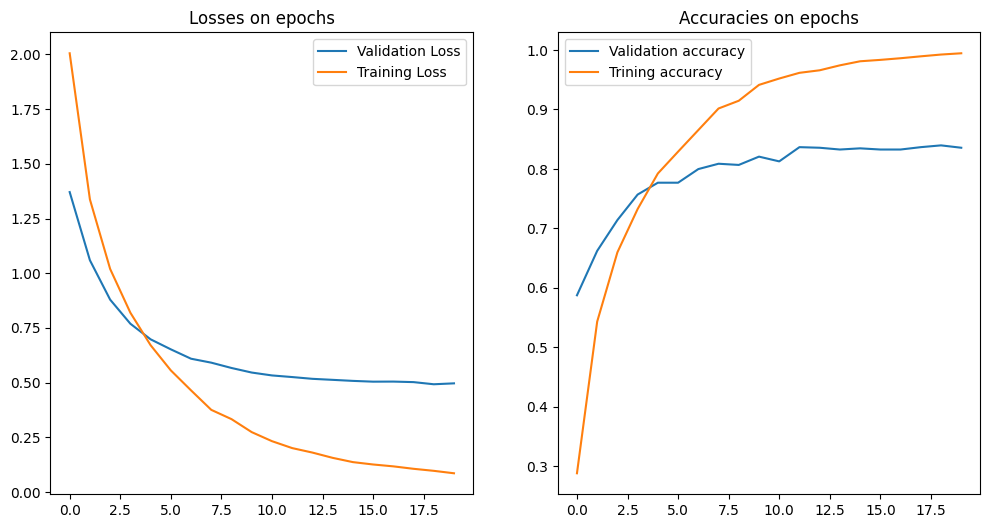

CPU times: user 18min 23s, sys: 9.81 s, total: 18min 33s
Wall time: 18min 38s


In [ ]:
%%time
aug_model = MushroomResNet(max_lr=0.004, min_lr=0.0005)
for param in aug_model.parameters():
    param.requires_grad = True
aug_trainer = pl.Trainer(
    max_epochs=20, logger=logger, callbacks=[MyPrintingCallback(), model_checkpoint]
)
aug_trainer.fit(aug_model, train_loader, valid_loader)

### Model with no distructive approach and augmentation

In this experiment the data is augmented, balanced and the non-distructive approach with padding is used.

In [ ]:
# Defining transformations
tfms = transforms.Compose(
    [
        ResizeWithPad(300, 300),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Defining dataloaders
train_data = datasets.ImageFolder("/content/data/train", transform=tfms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

valid_data = datasets.ImageFolder("/content/data/valid", transform=tfms)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=False)

test_data = datasets.ImageFolder("/content/data/test", transform=tfms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 11.2 M
1 | classifier        | Sequential         | 4.6 K 
2 | accuracy          | MulticlassAccuracy | 0     
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: valid_loss=1.1111, valid_acc=0.7344
Training is starting


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: valid_loss=0.7563, valid_acc=0.7620
Epoch 0: train_loss=1.4482, train_acc=0.4992


Validation: 0it [00:00, ?it/s]

Epoch 1: valid_loss=0.5533, valid_acc=0.8217
Epoch 1: train_loss=0.6359, train_acc=0.7994


Validation: 0it [00:00, ?it/s]

Epoch 2: valid_loss=0.5056, valid_acc=0.8376
Epoch 2: train_loss=0.3505, train_acc=0.9009


Validation: 0it [00:00, ?it/s]

Epoch 3: valid_loss=0.4863, valid_acc=0.8446
Epoch 3: train_loss=0.2022, train_acc=0.9507


Validation: 0it [00:00, ?it/s]

Epoch 4: valid_loss=0.4726, valid_acc=0.8476
Epoch 4: train_loss=0.1292, train_acc=0.9726


Validation: 0it [00:00, ?it/s]

Epoch 5: valid_loss=0.4875, valid_acc=0.8466
Epoch 5: train_loss=0.0818, train_acc=0.9869


Validation: 0it [00:00, ?it/s]

Epoch 6: valid_loss=0.4754, valid_acc=0.8566
Epoch 6: train_loss=0.0568, train_acc=0.9925


Validation: 0it [00:00, ?it/s]

Epoch 7: valid_loss=0.4741, valid_acc=0.8576
Epoch 7: train_loss=0.0419, train_acc=0.9955


Validation: 0it [00:00, ?it/s]

Epoch 8: valid_loss=0.4754, valid_acc=0.8516
Epoch 8: train_loss=0.0341, train_acc=0.9972


Validation: 0it [00:00, ?it/s]

Epoch 9: valid_loss=0.4683, valid_acc=0.8566
Epoch 9: train_loss=0.0269, train_acc=0.9983


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


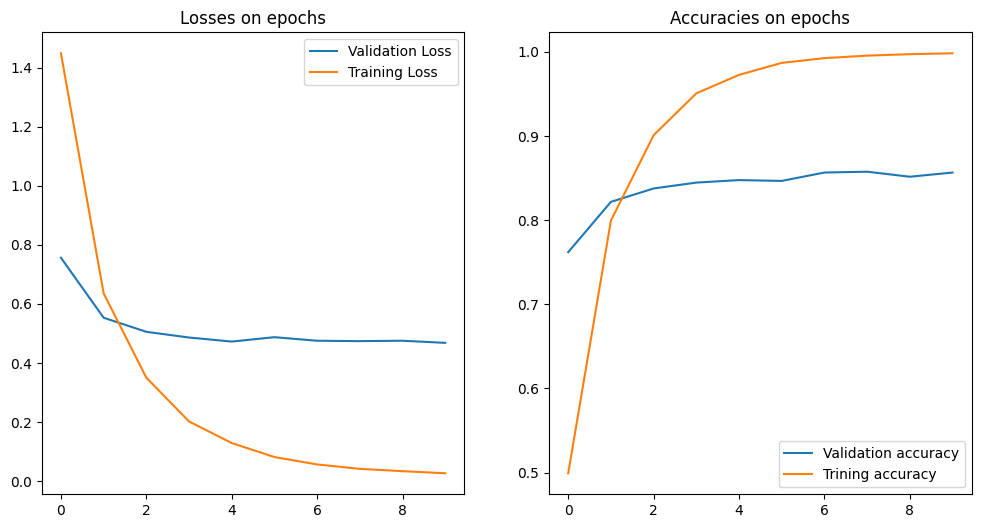

CPU times: user 45min 34s, sys: 21.9 s, total: 45min 55s
Wall time: 46min 19s


In [ ]:
# Fitting the trainer
%%time
padded_model = MushroomResNet(max_lr=0.004, min_lr=0.0005)
for param in padded_model.parameters():
    param.requires_grad = True
padded_trainer = pl.Trainer(
    max_epochs=10, logger=logger, callbacks=[MyPrintingCallback(), model_checkpoint]
)
padded_trainer.fit(padded_model, train_loader, valid_loader)

In [ ]:
# Saving checkpoint
torch.save(
    padded_model,
    "/content/drive/MyDrive/Colab/know_your_mashroom/padded_model_checkpoint.ckpt",
)

In [ ]:
# Testing on test set
padded_trainer.test(padded_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8606964945793152     │
│         test_loss         │    0.42618998885154724    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.42618998885154724, 'test_acc': 0.8606964945793152}]

In [ ]:
# # In case the runtime stops
# trainer = pl.Trainer()
# checkpoint_path = '/content/drive/MyDrive/Colab/know_your_mashroom/mushroom_exp/version_1/checkpoints/model-epoch=08-val_loss=1.2669.ckpt'
# loaded_model = MushroomResNet.load_from_checkpoint(checkpoint_path)
# loaded_model.eval()

In [ ]:
preds = trainer.predict(padded_model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
# Classification report
y = []
paths = []
for batch in test_loader:
    _, labels = batch
    paths.append(_.squeeze(0))
    y.append(labels.tolist())
y_true = np.array([item for sublist in y for item in sublist])

pred = [item.tolist() for item in preds]
y_hat = np.array([item for sublist in pred for item in sublist])
print(classification_report(y_true, y_hat, target_names=test_data.classes))

              precision    recall  f1-score   support

    Agaricus       0.81      0.79      0.80        53
     Amanita       0.91      0.90      0.91       112
     Boletus       0.94      0.96      0.95       160
 Cortinarius       0.82      0.78      0.80       125
    Entoloma       0.85      0.84      0.84        55
   Hygrocybe       0.88      0.94      0.91        47
   Lactarius       0.84      0.85      0.85       234
     Russula       0.84      0.84      0.84       173
     Suillus       0.78      0.78      0.78        46

    accuracy                           0.86      1005
   macro avg       0.85      0.85      0.85      1005
weighted avg       0.86      0.86      0.86      1005



* the easiest to recognise was Boletus
* highiest recall was noted for Boletus and Hygnocybe - most of those mushrooms are eadible

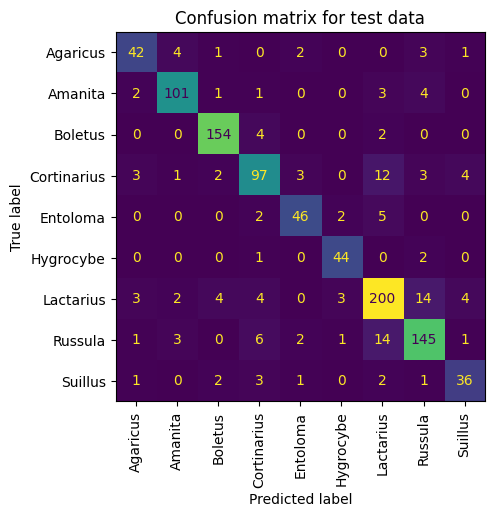

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
disp.plot(xticks_rotation=90, colorbar=False)
plt.title("Confusion matrix for test data");

## Visualization of results for most dangerous specie- Amanita

In [ ]:
# Getting Amanita paths
amanita_path = "/content/drive/MyDrive/Colab/know_your_mashroom/test/Amanita"
file_names = os.listdir(amanita_path)
amanita_paths = [os.path.join(amanita_path, file_name) for file_name in file_names]

In [ ]:
# Segragating paths into TP and FP
amanitas = []
not_amanitas = []
for path in amanita_paths:
    image = Image.open(path)
    if label_mapper[np.argmax(batch_predict([image]))] == "Amanita":
        amanitas.append(path)
    else:
        not_amanitas.append(path)

In [ ]:
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

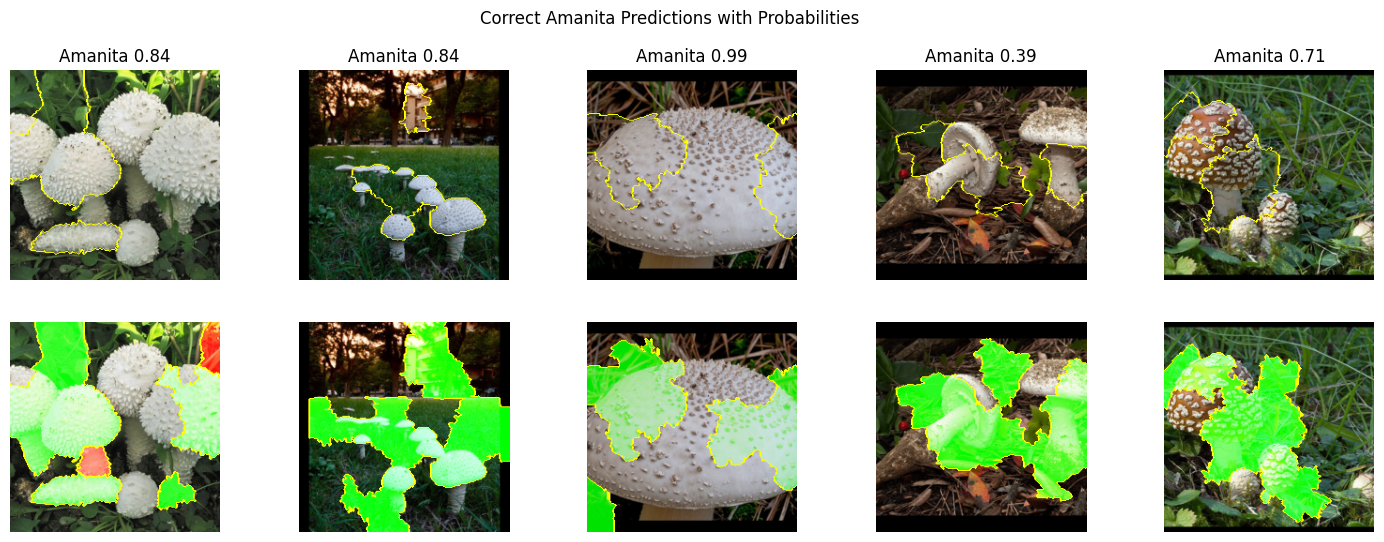

In [ ]:
# Plotting correct amanita predictions
plot_explanations(amanitas, "Correct Amanita Predictions with Probabilities")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

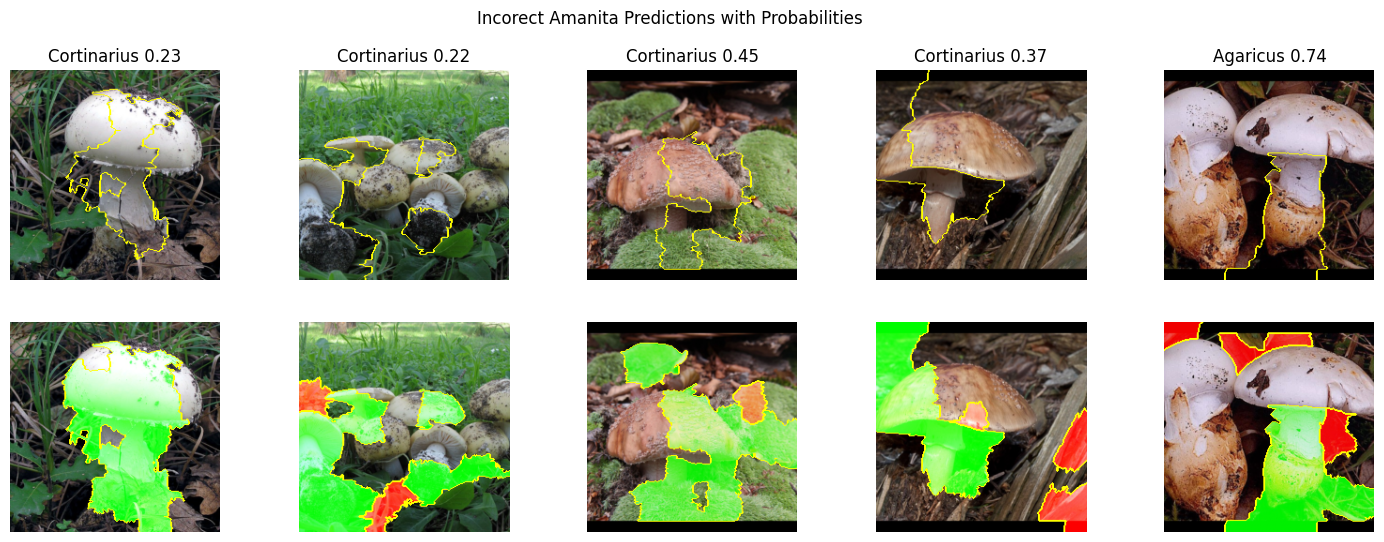

In [ ]:
# Plotting incorect predictions
plot_explanations(not_amanitas, "Incorect Amanita Predictions with Probabilities")

# Conclusions
* Data augmentation, dropout, no-distructive resizing and adjusting learning rate were the most important aspects in improvement of accuracy
* The task is hard as the shape of mushrooms is similar, some specific features like doths on the cup or colour made the destrinction easier
* Some not eadible mushrooms are recognized as eadible like Amanita mistakenly assigned to Agaricus or predicted species of other toxic mushrooms.
* The model has made the highiest number of mistakes on Rusulla and Lactarius which are visually similar. Both of them are toxic so they wouldn't cause poisoning.

# Improvements

* Using different method of loading and batching data as this would prevent unnecesary lines of code.
* Experimenting with unfreezing layers, different learning rates and batch sizes.
* Modeling on eadiable vs. uneadiable mushrooms and setting threshold to minimise poisoning - contacting mycologist.
* Checking different types of pretrained models from torchvision library.
* Checking results in tensorboard.
* Adding layers to the model.


Sources of code:
* non-distructive resizing: https://github.com/pytorch/vision/issues/6236
* lime interpretation: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb